

The effect of a 1 standard deviation increase in a feature on the log-odds of being in a higher ripeness class.


Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area


C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_9296\365943691.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')


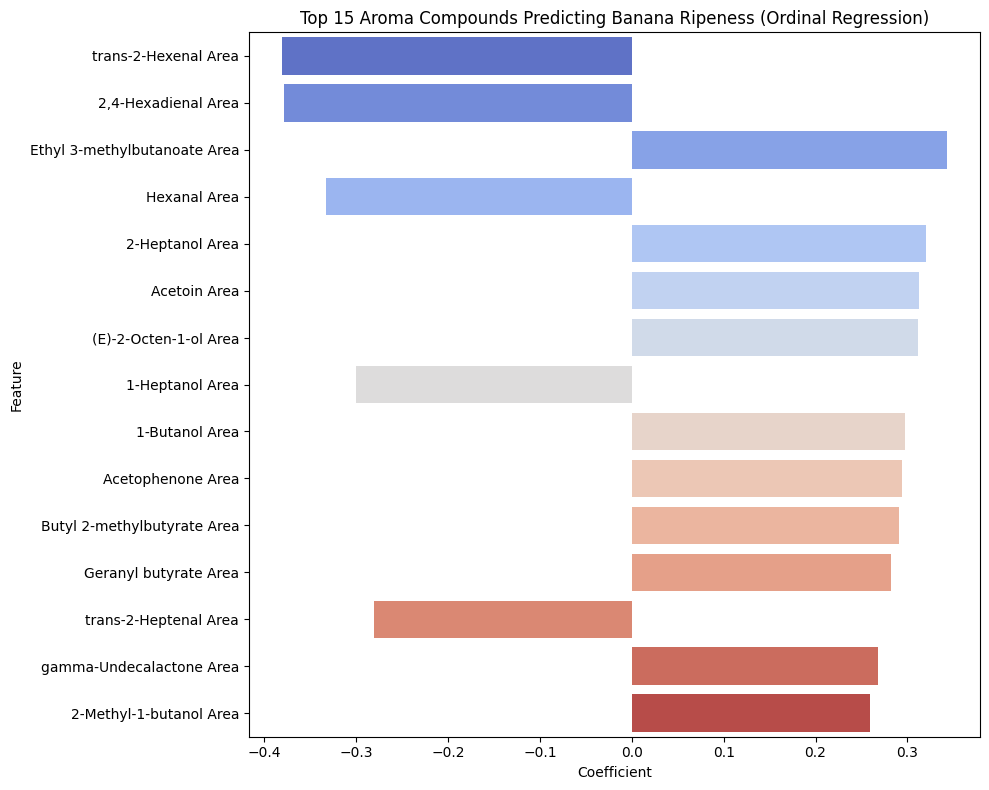

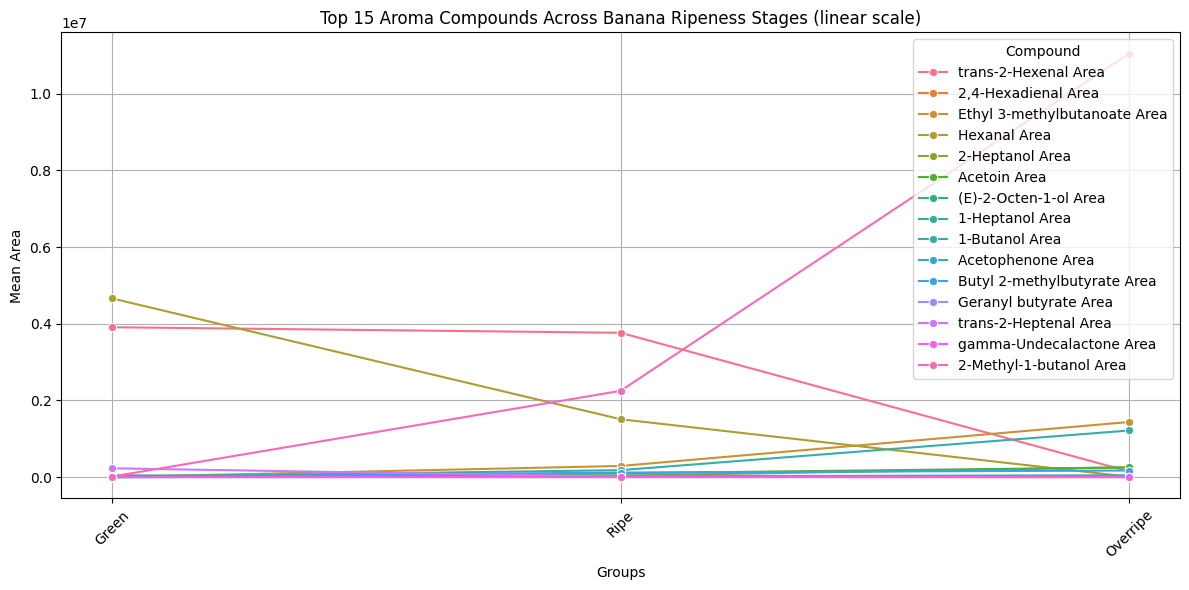

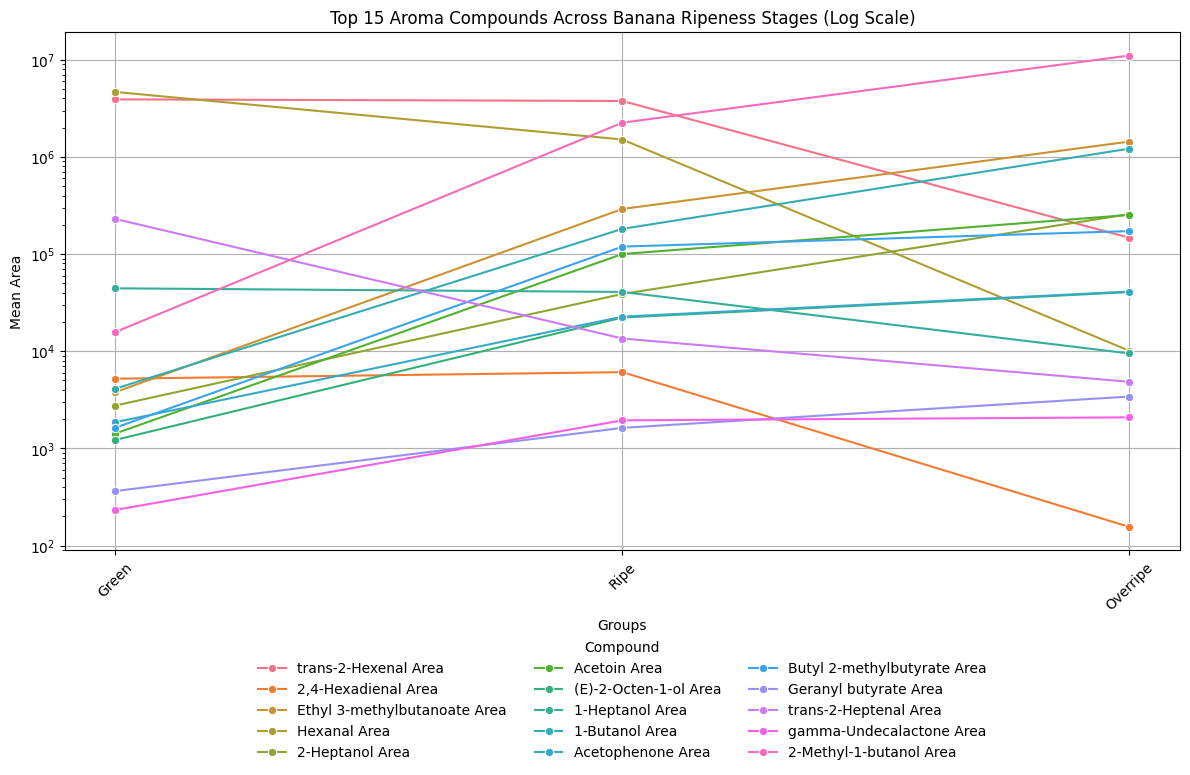

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from mord import LogisticAT  # Ordinal regression model


# parameter: this can be adjusted to show the number of top values to display in figures
top = 15

'''
Choice here between filled data or non-filled 
'''
# Load the dataset (group impute, nans filled with pseudocount)
#df = pd.read_csv("badata_imputed_filled.csv")

df = pd.read_csv('badata_imputed.csv')
'''
pick the preproces file carefully
'''


# Drop the first unnamed column as it's an index
df = df.drop(columns=[df.columns[0]])

# Identify and drop columns with any missing values
missing_cols = df.columns[df.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

df = df.drop(columns=missing_cols)

# Separate features and target
target = df['Groups']
features = df.drop(columns=['Groups'])

# Encode the target as ordinal: Green < Ripe < Overripe
ordinal_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
y = target.map(ordinal_map).values

#log features
X_log = np.log10(features)

# scale values
scaler = MinMaxScaler()
X = scaler.fit_transform(X_log)


# Fit ordinal regression model
model = LogisticAT()
model.fit(X, y)

# Get feature coefficients
coefficients = model.coef_
feature_names = features.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Plot top contributing features
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')
plt.title(f'Top {top} Aroma Compounds Predicting Banana Ripeness (Ordinal Regression)')
plt.tight_layout()
#plt.savefig("ordinal_top_features.png")
plt.show()



# Select top contributing features
top_features = coef_df.head(top)['Feature'].values

# Calculate mean values of top features grouped by ripeness
# reset index here ensures the y axis values are in original abundance space
grouped_means = df.groupby('Groups')[top_features].mean().reset_index()

# Melt the dataframe for plotting
melted_df = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')
# Ensure Groups are in the correct ordinal order
melted_df['Groups'] = pd.Categorical(melted_df['Groups'], categories=['Green', 'Ripe', 'Overripe'], ordered=True)

# Plot lineplot showing how compound levels change across ripeness stages
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (linear scale)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
#plt.savefig("top_compounds_lineplot.png")
plt.show()

# 2nd plot with log scale as data is compressed at bottom
plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.yscale('log')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True)
#plt.legend([],[], frameon=False)  # removes the legend
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # center it below the plot
    ncol=3,                       # number of columns (adjust as needed)
    title="Compound",
    frameon=False
)
plt.tight_layout()
#plt.savefig("top_compounds_lineplot(log).png")
plt.show()